In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Runs multiple output commands in the same cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
lag_window = 1;

In [4]:
%run -i 'DataLoader.py'

In [5]:
train = train[train.item_price<100000]
train = train[train.item_price>0]
train = train[train.item_cnt_day<999]

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935845 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 156.8+ MB


In [7]:
%run -i 'FeatureEngineering.py'

In [8]:
learning_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7497000 entries, 788970 to 5309604
Data columns (total 22 columns):
 #   Column                                   Dtype  
---  ------                                   -----  
 0   shop_id                                  int64  
 1   item_id                                  int64  
 2   date_block_num                           int64  
 3   month                                    int64  
 4   year                                     int64  
 5   days_in_month                            int64  
 6   item_cnt_month                           float64
 7   item_category_id                         int64  
 8   category_type_encoded                    int64  
 9   category_sub-type_encoded                int64  
 10  shop_city_encoded                        int64  
 11  item_cnt_day_lag1                        float64
 12  item_price_lag1                          float64
 13  daily_revenue_lag1                       float64
 14  item_cnt_avg_

In [9]:
# Separating data into train, validation, test
X_train = learning_data[learning_data['date_block_num'] < 33].drop(['item_cnt_month'], axis=1)
Y_train = learning_data[learning_data['date_block_num'] < 33]['item_cnt_month']
X_valid = learning_data[learning_data['date_block_num'] == 33].drop(['item_cnt_month'], axis=1)
Y_valid = learning_data[learning_data['date_block_num'] == 33]['item_cnt_month']
X_test = learning_data[learning_data['date_block_num'] == 34].drop(['item_cnt_month'], axis=1)

In [10]:
import xgboost as xgb

model = xgb.XGBRegressor(max_depth = 10, min_child_weight=0.5, subsample = 1, eta = 0.3, num_round = 1000, seed = 1)
model.fit(X_train, Y_train, eval_metric="rmse", eval_set=[(X_train, Y_train), (X_valid, Y_valid)], verbose=True, early_stopping_rounds = 10)

[23:09:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:0.93534	validation_1-rmse:1.00238
[1]	validation_0-rmse:0.84785	validation_1-rmse:0.94474
[2]	validation_0-rmse:0.79682	validation_1-rmse:0.92005
[3]	validation_0-rmse:0.76914	validation_1-rmse:0.91068
[4]	validation_0-rmse:0.75094	validation_1-rmse:0.90619
[5]	validation_0-rmse:0.74031	validation_1-rmse:0.90450
[6]	validation_0-rmse:0.73340	validation_1-rmse:0.90434
[7]	validation_0-rmse:0.72742	validation_1-rmse:0.90568
[8]	validation_0-rmse:0.72316	validation_1-rmse:0.90548
[9]	validation_0-rmse:0.71874	validation_1-rmse:0.90640
[10]	validation_0-rmse:0.71559	validation_1-rmse:0.90678
[11]	validation_0-rmse:0

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.3, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=10,
             min_child_weight=0.5, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, num_round=1000,
             random_state=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=1, subsample=1, tree_method='approx', validate_parameters=1,
             verbosity=None)

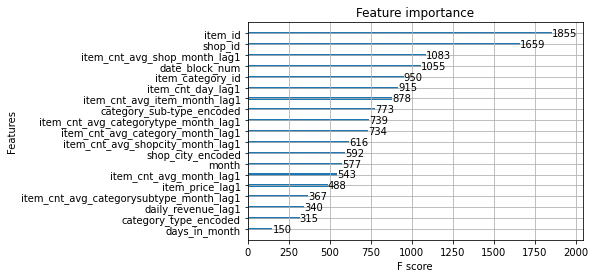

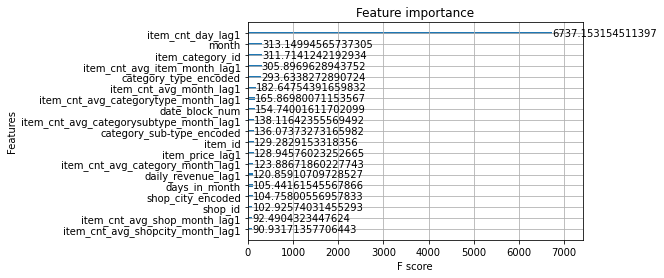

In [11]:
xgb.plot_importance(model);
xgb.plot_importance(model,importance_type="gain");

In [12]:
predictions = model.predict(X_test)
pred_dataframe = pd.DataFrame(predictions, columns = ['item_cnt_month'])
pred_dataframe['item_cnt_month'] = pred_dataframe['item_cnt_month'].clip(0,20)

In [14]:
submission = X_test[['shop_id','item_id']]
submission['item_cnt_month'] = predictions

FeatureEngineering.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [16]:
test['ID'] = test.index

In [17]:
submission = pd.merge(submission,test, on=['shop_id','item_id'],how = 'inner')
submission = submission[['ID','item_cnt_month']]

In [22]:
submission=submission.set_index('ID')
submission

,item_cnt_month
ID,
22987,0.101689
20994,0.176014
20995,0.101689
22492,0.090620
22491,0.092038
...,...
149575,0.132407
148799,0.284099
149242,0.106260


In [25]:
submission=submission.sort_index()

In [26]:
submission.to_csv('xgb_lag'+str(lag_window)+'.csv',index=True,index_label='ID') 